In [3]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss
import joblib

In [4]:
# 定义文件序号列表
snr_list = [-10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

file_path_train = []
file_path_test  = []
# 循环遍历每个文件序号，并加载相应的 CSV 文件
for snr in snr_list:
    file_path_train.append(f'../preprocessed/combined_features_{snr}.csv')
    file_path_test.append(f'../preprocessed/combined_features_{snr}_test.csv')

In [5]:
# 初始化字典存储X_train和y_train数据集
# scaler = StandardScaler()
X_trains = {}
y_trains = {}
X_tests = {}
y_tests = {}
# 循环处理每个文件
for size, file_path in zip(snr_list, file_path_train):
    # 读取数据集
    df = pd.read_csv(file_path)
    # 打乱数据集
    df = shuffle(df, random_state=42)
    # 分离标签和特征
    y_trains[size] = df['label']
    X_trains[size] = df.drop('label', axis=1)
for size, file_path in zip(snr_list, file_path_test):
    # 读取数据集
    df = pd.read_csv(file_path)
    # 打乱数据集
    df = shuffle(df, random_state=42)
    # 分离标签和特征
    y_tests[size] = df['label']
    X_tests[size] = df.drop('label', axis=1)


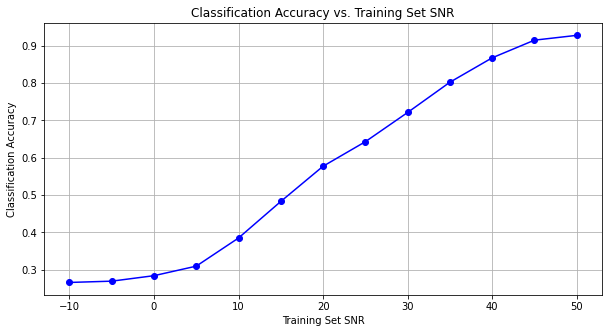

In [6]:
accuracies = []

# 使用 K-fold 交叉验证
k = 5  # 定义交叉验证的折数

# 训练模型并评估准确度
for snr in snr_list:
    # scaler = StandardScaler()
    X_train = X_trains[snr]
    # X_train = scaler.fit_transform(X_train)
    X_test  = X_tests [snr]
    # X_test  = scaler.transform(X_test)
    y_train = y_trains[snr]
    y_test  = y_tests [snr]
    model = xgb.XGBClassifier(eval_metric='logloss')
    # model.fit(X_train, y_train)
    # y_pred = model.predict(X_test)
    # accuracy = np.mean(y_pred == y_test)
    # accuracies.append((snr, accuracy))
    # 进行交叉验证并计算平均准确度
    scores = cross_val_score(model, X_train, y_train, cv=k, scoring='accuracy')
    mean_accuracy = np.mean(scores)
    accuracies.append((snr, mean_accuracy))
    # kfold 交叉验证
    # k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # fold_accuracies = []
    # for train_index, test_index in k_fold.split(X_train, y_train):
    #     X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
    #     y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]
        
    #     model.fit(X_fold_train, y_fold_train)
    #     y_pred = model.predict(X_fold_test)
    #     fold_accuracy = np.mean(y_pred == y_fold_test)
    #     fold_accuracies.append(fold_accuracy)
    # accuracies.append((snr, np.mean(fold_accuracies)))
# 数据排序（可选，如果数据集未按顺序添加）
accuracies.sort()

# 分解列表以便绘图
sizes, accuracy_scores = zip(*accuracies)

# 绘制图形
plt.figure(figsize=(10, 5))
plt.plot(sizes, accuracy_scores, marker='o', linestyle='-', color='b')
plt.title('Classification Accuracy vs. Training Set SNR')
plt.xlabel('Training Set SNR')
plt.ylabel('Classification Accuracy')
plt.grid(True)
plt.show()


# 加上递归特征消除和交叉验证后

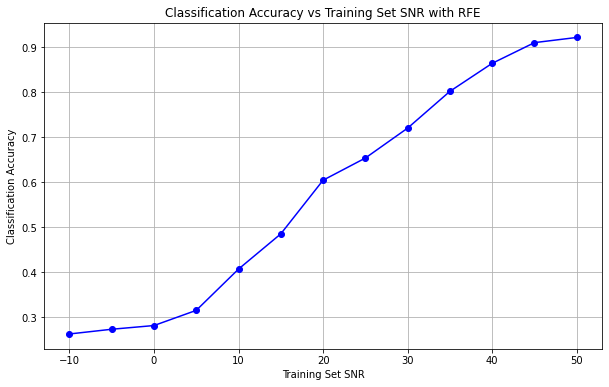

In [7]:
accuracies_ = []

# 进行交叉验证和特征选择
for snr in snr_list:
    X_train = X_trains[snr]
    y_train = y_trains[snr]
    X_test  = X_tests [snr]
    y_test  = y_tests [snr]
    # 创建XGBoost模型
    estimator = xgb.XGBClassifier(eval_metric='logloss')
    # 创建RFE与交叉验证
    rfecv = RFECV(estimator=estimator, step=1, cv=StratifiedKFold(10), scoring='accuracy')
    rfecv.fit(X_train, y_train)
    # 保存模型到磁盘
    model_filename = f'./model_save/xgb_model_snr_{snr}.joblib'
    joblib.dump(rfecv, model_filename)
    # 使用训练好的 RFE 模型对测试集进行预测
    y_pred = rfecv.predict(X_test)
    accuracy = np.mean(y_pred == y_test)
    accuracies_.append(accuracy)

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(snr_list, accuracies_, marker='o', linestyle='-', color='b')
plt.title('Classification Accuracy vs Training Set SNR with RFE')
plt.xlabel('Training Set SNR')
plt.ylabel('Classification Accuracy')
plt.grid(True)
plt.show()

In [8]:
print(accuracies)
print(accuracies_)

[(-10, 0.26618749999999997), (-5, 0.269625), (0, 0.2843125000000001), (5, 0.30981250000000005), (10, 0.3851875), (15, 0.48306250000000006), (20, 0.5773124999999999), (25, 0.643), (30, 0.72125), (35, 0.8022500000000001), (40, 0.8675625), (45, 0.914875), (50, 0.92775)]
[0.26275, 0.27325, 0.2815, 0.31525, 0.407, 0.48525, 0.6045, 0.65375, 0.72025, 0.802, 0.86425, 0.91025, 0.92175]


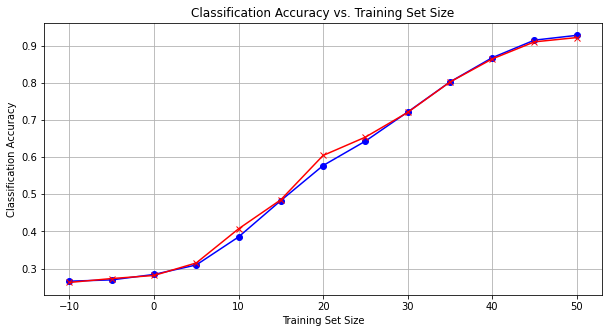

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(sizes, accuracy_scores, marker='o', linestyle='-', color='b')
plt.plot(sizes, accuracies_, marker='x', linestyle='-', color='r')
plt.title('Classification Accuracy vs. Training Set Size')
plt.xlabel('Training Set Size')
plt.ylabel('Classification Accuracy')
plt.grid(True)
plt.show()

# 模型保存和加载方法

In [10]:
# # 加载模型
# model_filename = f'./model_save/xgb_model_size_{size}.joblib'
# rfecv_loaded = joblib.load(model_filename)

# # 对测试集进行预测
# y_pred_loaded = rfecv_loaded.predict(X_test)